# **Malaria Detection**

##<b>Problem Definition</b>
<b>**The context:** Why is this problem important to solve?</b><br>
<br>
<p>
A traditional diagnosis of malaria detection, involves careful inspection by experience professional to distinguish healthy and infect red
blood cells. It is tedious and time consuming job as well as it depends on accuracy of person who is doing inspection e.g. human expertise.
</p>
<p>
In this project, we are trying to automate this process to help diagnosis the problem as described above to have AI/ML based solution
that can support and enhance the diagnosis of malaria detection.
</p>
    
<b>**The objectives:** What is the intended goal?</b><br>
<br>
<p>
Our intention in this project is to streamline diagnosis process which heavily depends on human expertise and naked eye's observation
capabilities. Intended goal of this project is to explore opportunities to develop and deploy AI/ML based deep learning solution to detect
and classify if the images of red blood cell collected from the spcimen of patients are infected with plasmodium parasite or not. In turn it
will enable and provide tool for professional to expedite their investigation as well save time in determining a huge number of population.
that faces this pandemic over the years in underdeveloped part of the world.
This tool's purpose is to support and enhance diagnostics capabilites and provide instrument that can expedite the diagnostics process.
</p>

<b>**The key questions:** What are the key questions that need to be answered?</b><br>
<br>
<p>
A Key questions that need to be answered are following:
1. Can we build a model: AI/ML based that can aid the detection of parasite from the image of red blood cell given as test speciment.
2. Can we classifiy the red blood cell images into infected/not infected cells.
</p>
<br>
<b>**The problem formulation:** What is it that we are trying to solve using data science? </b> <br>
<br>
<p>As a part of solution we intend to solve to following:
1. Ability to divide labelled data-set into training and testing data set. In this case it is already divided.
2. Perform EDA on the data set to explore common behavior, patterns and attributes that can be used to design a AI/ML software based models.
3. Design varoius models based on ANN/CNN etc that can be trained and tested against the divided data sets.
4. Tune the model to the outcome that closes matches our requirement.
5. Design/Conclude the model, if it is possible to deploy in the enviornment. At what capacity one can trust the model and use to help/aid
their decision process.
6. Future training of the model and refinements
7. Performance metrics as well as cost of deploying such solutions. (if acceptable to deploy)
</p>

## <b>Data Description </b> </br>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive <b>
There is no need to mount the drive as i am using jupyter notebook on anaconda where the images are stored locally to the folder. So this step is not needed.

In [1]:
# No need to mount the drive as the script uses local folders to open the images and anaconda environment
# to run the scripts.

### <b>Loading libraries</b>

In [2]:
# uncomment the below line if cv2 is not accessible. - once run you dont need to do that again.
#!pip install opencv-python opencv-python-headless
import cv2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from typing import Tuple, Iterable

### <b>Let us load the data</b>

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [3]:
# load the existing files into tensorflow data set - basically it has
# infected and uninfected labels - which are considered classes
# we would like to load images as 64 x 64 as RGB channel into 100 batch sizes.
# now these options can be changed - initially started with 252 x 252 which was
# causing lot of problem , a kernel resets everytime and the cpu was not able to 
# keep up. so make sure - the size is optimized for processing
# it returns tensorflow.data.DataSet

def create_image_dataset(
    directory: str,
    image_size: tuple = (64, 64),
    batch_size: int = 100
) -> tf.data.Dataset:
    return tf.keras.utils.image_dataset_from_directory(
        directory=directory,
        label_mode="int",
        image_size=image_size,
        batch_size=batch_size
    )
# the images are extracted locally on the device and it is not uploaded to google drive.
# so there is no need to mount the google drive. THe environment used is anaconda and jupyter notebook.

# Create a training dataset - this will be tensorflow dataset object. 
train_ds = create_image_dataset(directory='cell_images/train')

# Create a testing dataset of similar type. 
test_ds = create_image_dataset(directory='cell_images/test')

Found 24958 files belonging to 2 classes.
Found 2600 files belonging to 2 classes.


The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [4]:
# convert the dataset into 4D array as to process for the convolutional network this is a basic need.
# this shall be done for both the training as well as testing data set.
# there is probably no need to do this as CNN can directly take the tensorflow.dataset as is to consume
# into its model.
def convert_to_4d_array(dataset: Iterable) -> Tuple[np.ndarray, np.ndarray]:
    '''
    convert image array into 4d image consumable
    for cnn modeling
    the dataset has image and label lists that can be extracted
    image list and lable list.
    '''
    images_list = []
    labels_list = []

    # extract image and labels from the dataset for processing 
    # The warning for OUT_OF_RANGE is basically for the last - batch as it ends early typically
    # a good practice is to divide data into equal batches - but with train data set it is not possible as
    # there is a number which is almost prime - after you divide it by 2. There is no bigger factor of that
    # number that can be used into batch size.
    for images, labels in dataset:
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())
    
    X = np.concatenate(images_list, axis=0)
    y = np.concatenate(labels_list, axis=0)
    
    return X, y

X_train, y_train = convert_to_4d_array(train_ds)
X_test, y_test = convert_to_4d_array(test_ds)

2025-04-10 16:59:08.622471: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-10 16:59:08.912792: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


###<b> Check the shape of train and test images

In [5]:
print("Image shape:", X_train.shape)
print("Label shape:", y_train.shape)

Image shape: (24958, 64, 64, 3)
Label shape: (24958,)


###<b> Check the shape of train and test labels

In [ ]:
print("Image shape:", X_test.shape)
print("Label shape:", y_test.shape)

# the image in the data set are arranged into 100 image batch size
# it shows the images are already in 4D
for batch in train_ds.take(1):
    images,label = batch
    print( "Image Shape on the dataset:", images.shape )

Image shape: (2600, 64, 64, 3)
Label shape: (2600,)
Image Shape on the dataset: (100, 64, 64, 3)


####<b> Observations and insights: </b>

<p> Based on the Shape attributes - we know that the testing data set: has 24958 images each with 64x64 size - as we loaded using the previous image loading api. It has 3 channels - which represents each RGB components.

For the testing data set - we have 2600 entries - the images size and channels is similar to the training data set.

The label data set is single dimenstion totalling 24958 into training dataset and 2600 in to testing data set. 
</p>

<p>
It is important to know the numbers and shape - because we will be using the numebrs to find out which model is more closer to the number and how model is able to perform in terms of mis-classification and proper classificaiton - the confusion metrics is a simple way to do the comparision our goal is to reduce false +/- readings into confusion metrics. We will look at this number closely into performance of each model.
</p>

### <b>Check the minimum and maximum range of pixel values for train and test images

In [7]:
# Its good to check minimum and maximum range of pixel however not sure if this is going to provide any
# valuable information for the classificaiton or distingushing patterns in the dataset
def get_min_max_pixel_values( dataset ):
    '''get min and max of image'''
    min_pixel_value = float( 'inf' )  # int with the max 
    max_pixel_value = float( '-inf' )  # int with min

    for images, labels in dataset:
        min_pixel_value = min( min_pixel_value, tf.reduce_min( images ).numpy() )
        max_pixel_value = max( max_pixel_value, tf.reduce_max( images ).numpy() )
    
    return min_pixel_value, max_pixel_value

# Get min and max pixel values for training and test datasets
train_min, train_max = get_min_max_pixel_values( train_ds )
test_min, test_max = get_min_max_pixel_values( test_ds )

print(f"Training dataset - Min pixel value: { train_min }, Max pixel value: { train_max }")
print(f"Test dataset - Min pixel value: { test_min }, Max pixel value: { test_max }")

# Access class names and store it
class_names = train_ds.class_names
print(f"Class names: {class_names}")


Training dataset - Min pixel value: 0.0, Max pixel value: 255.0
Test dataset - Min pixel value: 0.0, Max pixel value: 255.0
Class names: ['parasitized', 'uninfected']


2025-04-10 16:59:10.423951: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


####<b> Observations and insights:</br>
<p>
THe max and min is 255 and 0, which means the range of the pixel is all possible values in RGB range. there is nothing that stands out in terms of minimum or maximum values for the pixel for our data exploration. It is good to know, as in certain cases the pixel colors are prominent and there is no specific color pixel present at all. In those circumstances it is important to notice such data and plan or enhance model to leverage certain traiits.
</p>

###<b> Count the number of values in both uninfected and parasitized 

In [8]:
# Lets pen out how many data we have in each class for training and testing data set - this way we know what to expect when 
# the model is evaluated. 
def count_classes( dataset ):
    '''count number of items in each class per dataset'''
    class_counts = { 0:0, 1:0 }

    for images, labels in dataset:
        for label in labels.numpy():
            class_counts[label] +=1 
    return class_counts

train_class_counts = count_classes( train_ds )
test_class_counts = count_classes( test_ds )

In [9]:
print( f"total count in training set: {class_names[0]}: {train_class_counts[0]} and {class_names[1]}: {train_class_counts[1]}" )
print( f"total count in test set: {class_names[0]}: {test_class_counts[0]} and {class_names[1]}: {test_class_counts[1]}" )

total count in training set: parasitized: 12582 and uninfected: 12376
total count in test set: parasitized: 1300 and uninfected: 1300


###<b>Normalize the images

In [10]:
# for CNN the image data shall be normalized which means we need to bring back between 0-1 range
# the way to it similar to elective project - however it was more of monochrome image - here was have 
# RGB image - for normalization it does not impact - so we will follow the similar pattern of
# dividing each pixel by 255
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# normalize the training and data-set we are going to use this for the rest of the modeling.
train_ds_normalized = train_ds.map(normalize_image)
test_ds_normalized = test_ds.map(normalize_image)


In [11]:
print("Normalized image shape Training:", X_train_normalized.shape)  # (num_samples, height, width, channels)
print("Normalized image shape Test:", X_test_normalized.shape)  # (num_samples, height, width, channels)

Normalized image shape Training: (24958, 64, 64, 3)
Normalized image shape Test: (2600, 64, 64, 3)


####<b> Observations and insights:</b>
<p>
There are 24948 images in training set and 2600 images in testing set. They are loaded as 64 by 64 images size and there are 3 channels - representing RGB colors.
</p>

###<b> Plot to check if the data is balanced

In [12]:
def show_bar_plot( dataset, name='training' ):
    ''' show bar plot for the data set'''
    count_class = count_classes( dataset )
    # Plotting the class distribution for training set
    sns.barplot(x=list(count_class.keys()), y=list(count_class.values()))
    plt.title( f'Class Distribution in {name} Dataset')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

2025-04-10 16:59:13.769862: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


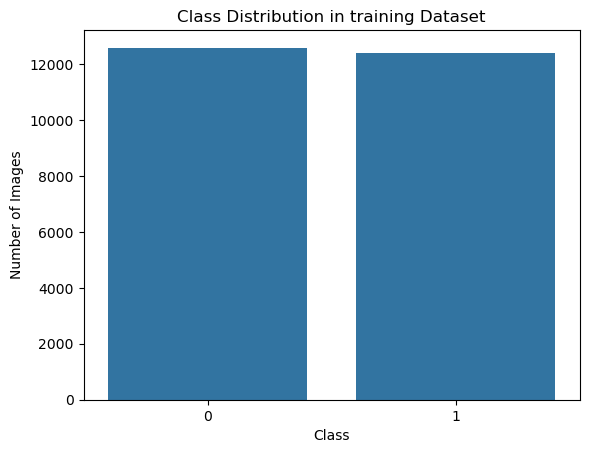

In [13]:
show_bar_plot( train_ds )

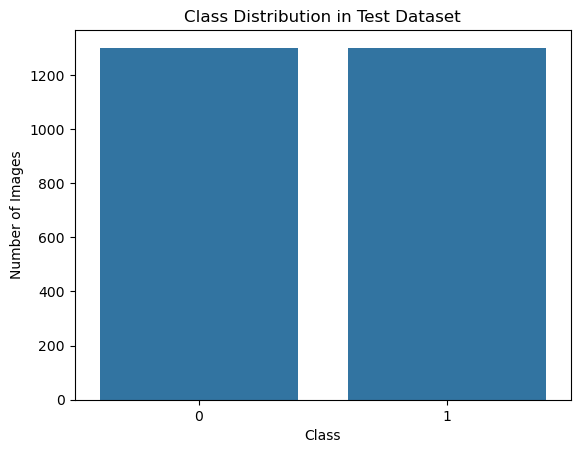

In [14]:
show_bar_plot( test_ds , name='Test' )

####<b> Observations and insights: </b> <br>
<p>
The Sample plot on Training class and testing class shows proper balance of samples. It does not show any problem moving forward in terms of imbalance is concerned.
</p>

### <b>Data Exploration</b>
Let's visualize the images from the train data

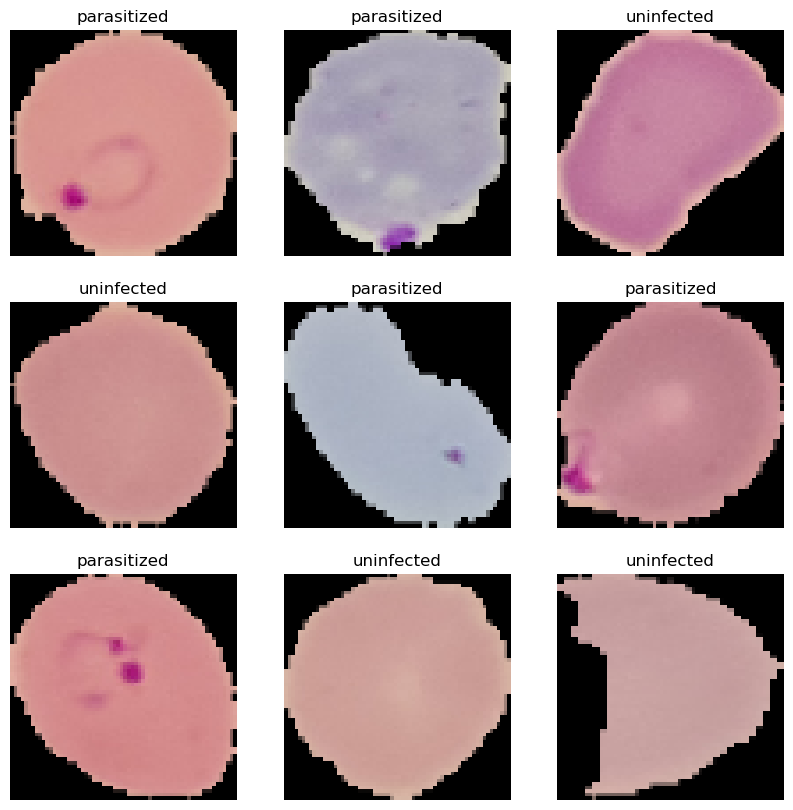

In [15]:
def show_3_by_3_image_of_dataset( dataset ):
    ''' show 3x3 image matrix for the dataset '''
    images, labels = next(iter(dataset))

    # Plot a few images from the batch
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off") 

    plt.show()

show_3_by_3_image_of_dataset( train_ds )

####<b> Observations and insights:</b>
<br><p>The one clear distinction is that the uninfected one are clear one where the infected one has visible patterns in the cell. I believe these patterns can be modeled into the AI to better predict the classificaiton. It also says uninfected one are clear and many of them does not show impurites in terms of pink circles or arches</p>

###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

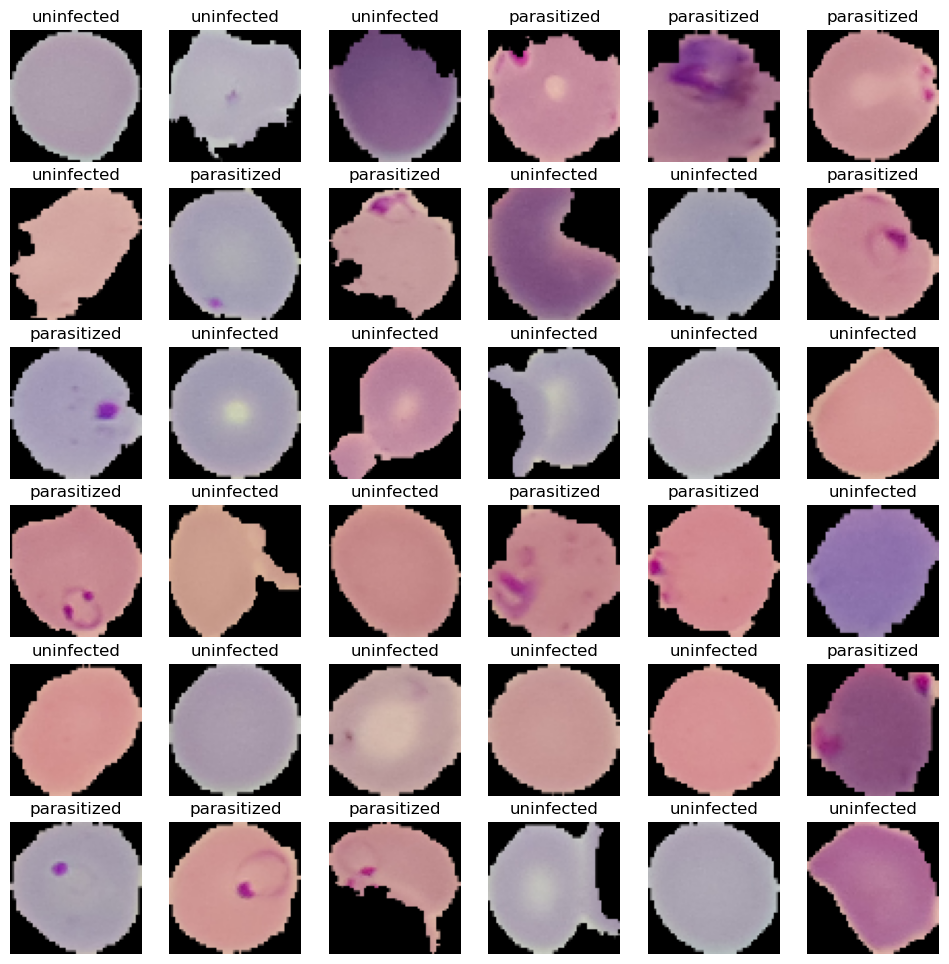

In [16]:
def show_6_by_6_image_of_dataset( dataset ):
    '''show 6x6 regular rgb image'''
    # Get one batch of images and labels
    images, labels = next(iter(dataset))
    plt.figure(figsize=(12, 12))
    for i in range(36):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

    plt.show()

show_6_by_6_image_of_dataset( train_ds )

####<b>Observations and insights:</b> <br>

<p>Looking at the images in 3 x 3 and 6 x 6 columns of the data - there is no easy way to find out if the infect and parasitized images can be figured out easily - there is definitely a dots that are visible in parasitized images - for sure. which can be a definite difference compared to uninfected cells.</p>

<p>With the model probably we shall be able to figure out these dots in the cells that can make model better and our way to classify the problem better.</p>


###<b> Plotting the mean images for parasitized and uninfected

In [17]:
# there shall be better way to just get the average - see if we can find it
# Lets find the sum and then divide by the total data set 
parasitized_sum = np.zeros((64, 64, 3), dtype=np.float32)
uninfected_sum = np.zeros((64, 64, 3), dtype=np.float32)

parasitized_count = 0
uninfected_count = 0

for images, labels in train_ds:
    for i in range(len(labels)):
        if labels[i].numpy() == 1:  # Uninfected class
            uninfected_sum += images[i].numpy()
            uninfected_count += 1
        elif labels[i].numpy() == 0:  # Parasitized class
            parasitized_sum += images[i].numpy()
            parasitized_count += 1

mean_parasitized_image = parasitized_sum / parasitized_count
mean_uninfected_image = uninfected_sum / uninfected_count

<b> Mean image for parasitized

(-0.5, 63.5, 63.5, -0.5)

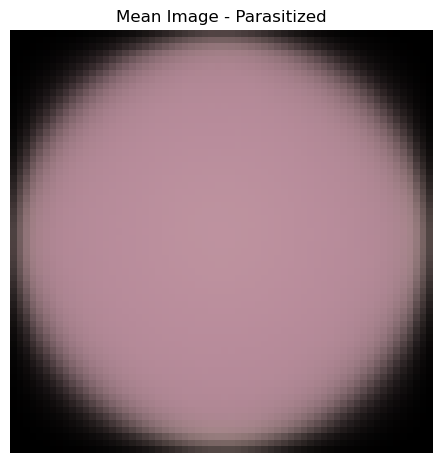

In [18]:
# Plot the mean images
plt.figure(figsize=(12, 6))

# Plot the mean image for the parasitized class
plt.subplot(1, 2, 1)
plt.imshow(mean_parasitized_image.astype("uint8"))
plt.title("Mean Image - Parasitized")
plt.axis("off")

<b> Mean image for uninfected

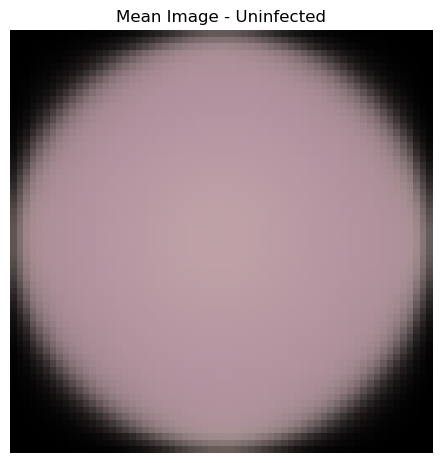

In [19]:
# Plot the mean images
plt.figure(figsize=(12, 6))

# Plot the mean image for the uninfected class
plt.subplot(1, 2, 2)
plt.imshow(mean_uninfected_image.astype("uint8"))
plt.title("Mean Image - Uninfected")
plt.axis("off")

plt.show()

####<b> Observations and insights:</b><br>
<p>
The mean infected and uninfected images does not provide any way to differentiate images that can easily guide us a way to classify if the images is infected with malaria virus or not. The regular images are better instead of the avg image.</p><br>
<p> The mean image has lot of blur - it does not even convey the outer shape - as well the borders are showing texture of the pixels</p>

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [20]:
# define a converter function that will act as a map to do rgb->hsv
def rgb_to_hsv_batch(images, labels):
    images_hsv = tf.image.rgb_to_hsv(tf.cast(images, tf.float32) / 255.0)  # Normalize to [0, 1]
    return images_hsv, labels

# convert
train_ds_hsv = train_ds.map(rgb_to_hsv_batch)


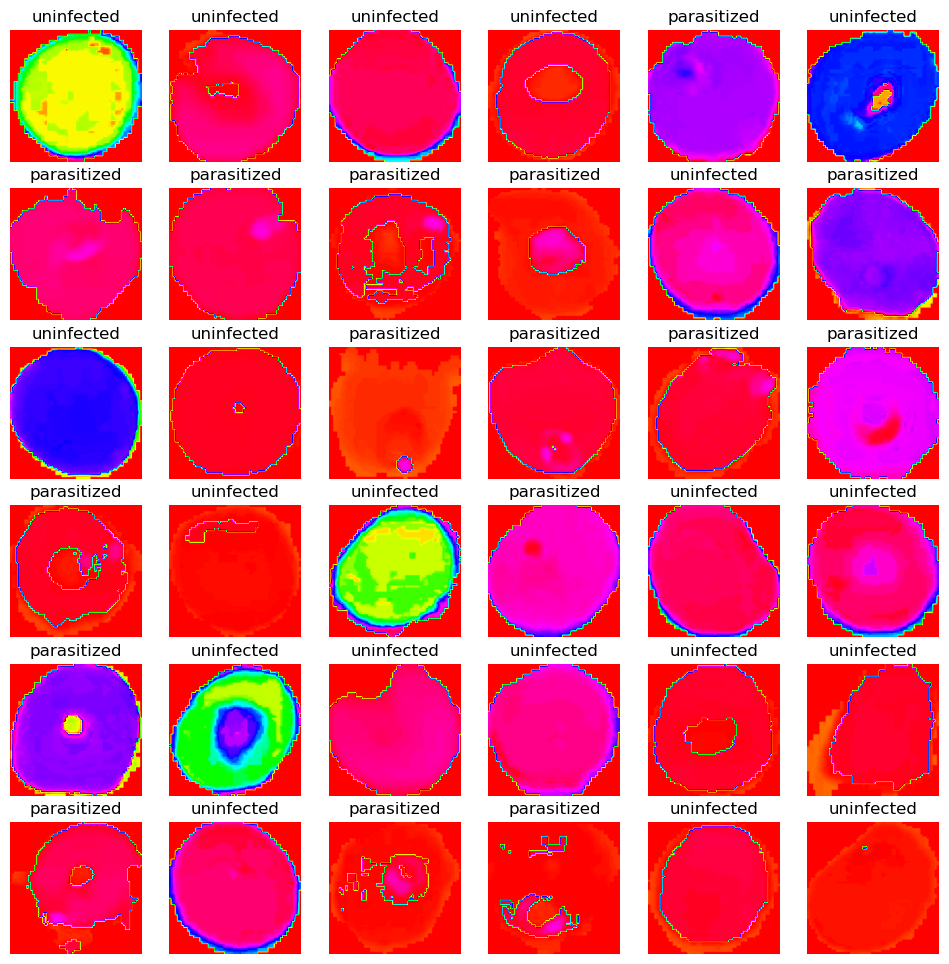

In [21]:
def show_6_x_6_hsv_images( dataset ):
    '''show 6x6 matrix of HSV images'''
    # Visualize a batch from the HSV dataset
    # Get a batch of images
    images_hsv, labels = next(iter(dataset))

    plt.figure(figsize=(12, 12))
    for i in range(36):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images_hsv[i, :, :, 0], cmap='hsv')
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

    plt.show()

show_6_x_6_hsv_images( train_ds_hsv )

###<b> Converting the test data

In [22]:
# Map the conversion function over the dataset
test_ds_hsv = test_ds.map(rgb_to_hsv_batch)

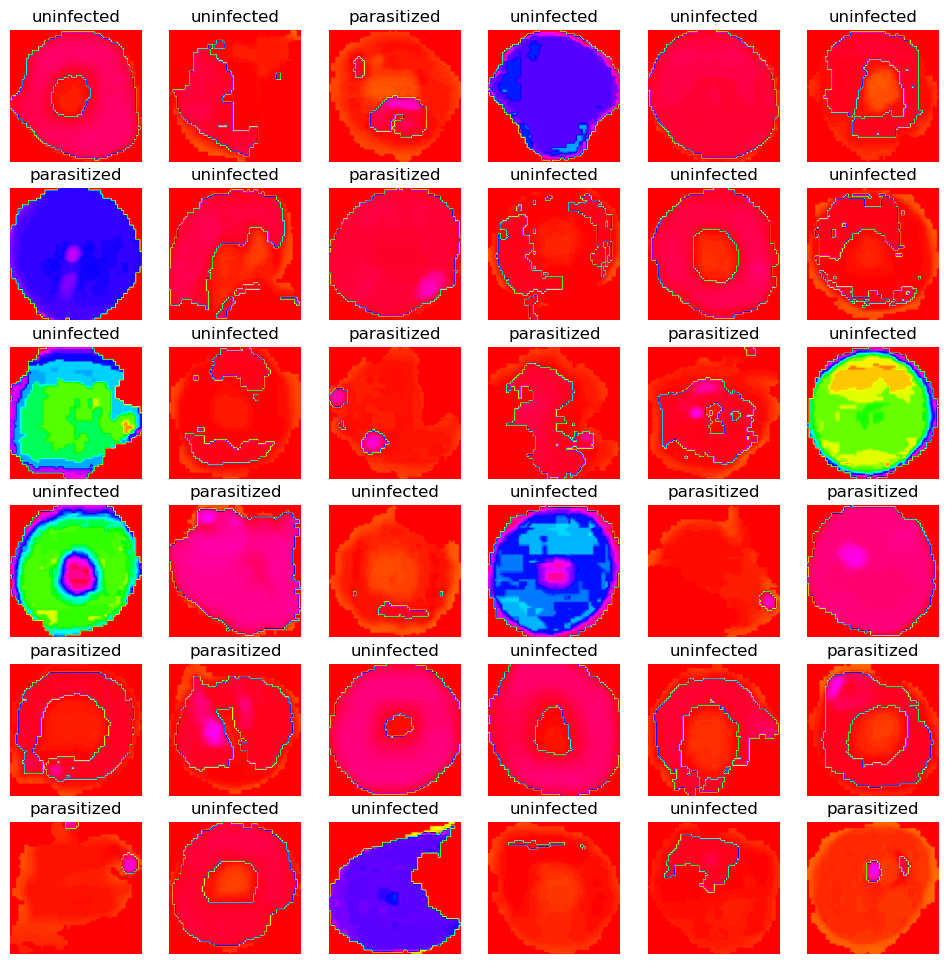

In [23]:
# show HSV images mainly 6x6 matrix
show_6_x_6_hsv_images( test_ds_hsv )

####<b>Observations and insights:</b>
<p>
HSV images are more confusion and does not provide a clear classification to our eyes. RGB images are better in terms of clear difference. The HSV images are typically shows lot of reds and some blues there are no clear indicator that can be used. There are some mixed bags - like one of the blue cells shows up infect and uninfected at the same time. This is a clear indication of confusio and it may not help in modeling if these confusions are visible even through naked eyes.</p><br>
<p>
in my opinion, RGB images are still better to stick with the modeling.
</p>

###<b> Processing Images using Gaussian Blurring

In [24]:
# a function that converts regular RGB image into blurred images using open CV
# library's gaussian blur method.
# for blurring it needs to take normalized images - passing regular image throws error.
def convert_to_blurred_images( data_set ):
  '''coverts dataset - containing normnalized image into blurred image'''
  imgs = [] 

  for i in np.arange(0, 100, 1):
    b = cv2.GaussianBlur(data_set[i], (5, 5), 0)
    imgs.append(b)
  imgs = np.array(imgs) 
  return imgs

# convert the normalized train data set into blurred image
train_blurred_imgs = convert_to_blurred_images( X_train_normalized )

# convert the test data set normalized image into blurred image
test_blurred_imgs = convert_to_blurred_images( X_test_normalized )

###<b> Gaussian Blurring on train data

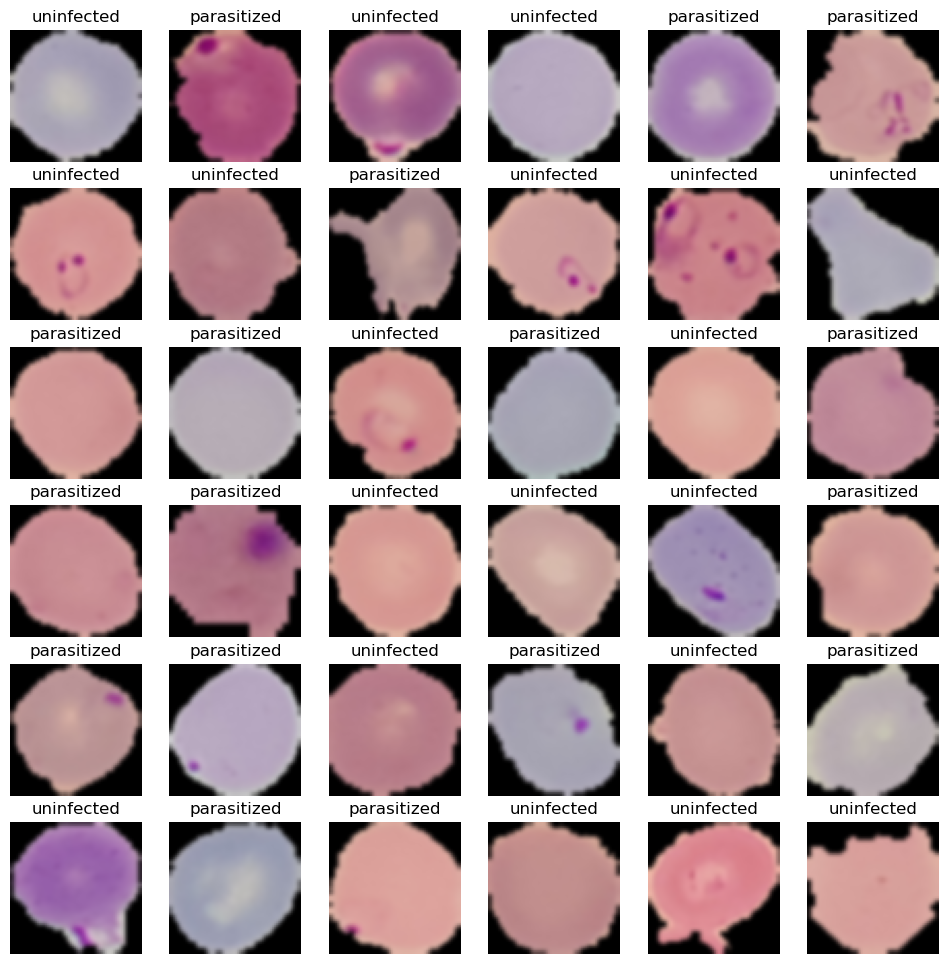

In [25]:
def show_6_x_6_blurred_images( blurred_imgs ):
    '''shows 6x6 blurr images - it is similar to other funciton but just called out to look different.'''
    plt.figure(figsize=(12, 12))
    for i in range(36):
        plt.subplot(6, 6, i+1)
        plt.imshow(blurred_imgs[i])
        plt.title(class_names[labels[i].numpy()])
        plt.axis('off')
    plt.show()
# show training images - that are blurred.
show_6_x_6_blurred_images( train_blurred_imgs )

###<b> Gaussian Blurring on test data

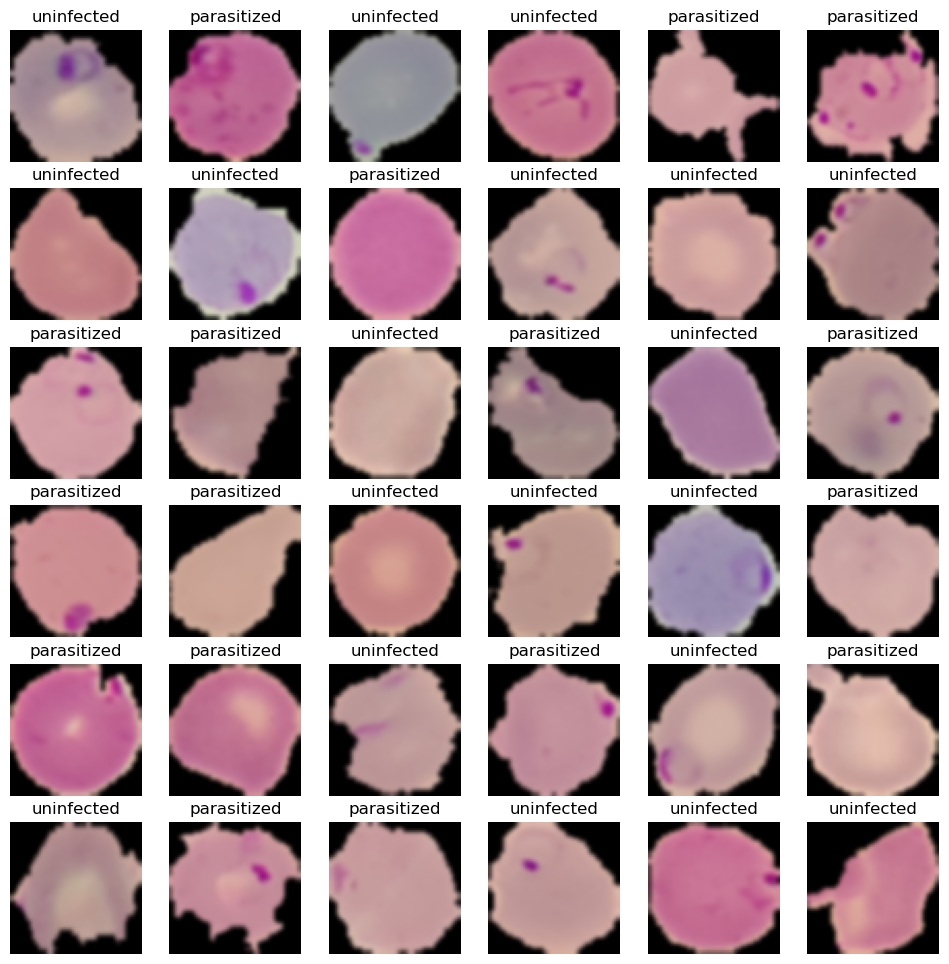

In [26]:
# show the testing blurred images
show_6_x_6_blurred_images( test_blurred_imgs )

####<b>**Observations and insights:** </b></br>
<p>
blurred image also does not provide better classification than RGB images.
</p>

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try? <br>
<p>
No blurring does not provide any added advantage in my opinion. Yes, it can certainly help in some cases but this may not be the case for it.
Certain things we can try: but i am not sure. It may be to create monochrome images or - some other modelling - but i am not sure if it is going to make major difference so it is bette to start playing with some models and see its output.
</p>

## **Model Building**

<div class="alert alert-block alert-info">
<b>Base Model:</b> Model 1
</div>

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [27]:
# already imported required libraries. so it is good.

####<B>One Hot Encoding the train and test labels

In [28]:
# Function to one-hot encode the labels
def one_hot_encode(labels, num_classes):
    '''a mapping function for the one hot encoding'''
    return tf.one_hot(labels, num_classes)


num_classes = 2

# Function to apply one-hot encoding to each batch in the dataset
def one_hot_encode_batch(images, labels):
    '''apply one hot encoding to the batch using one_hot_encode'''
    labels_one_hot = one_hot_encode(labels, num_classes)
    return images, labels_one_hot

# map the one hot encoding funciton.
train_ds_one_hot = train_ds_normalized.map(lambda x, y: one_hot_encode_batch(x, y))
test_ds_one_hot = test_ds_normalized.map(lambda x, y: one_hot_encode_batch(x, y))

type( train_ds_one_hot )


tensorflow.python.data.ops.map_op._MapDataset

###<b> Building the model

In [29]:

def create_base_cnn_model( num_classes = 2 ):
    '''a base cnn model - we will keep explore other models based on that'''
    model = models.Sequential([
        # Convolutional Layer 1
        tf.keras.layers.Input(shape=(64, 64, 3)),
        layers.Conv2D(32, (3, 3), activation='relu' ),
        layers.MaxPooling2D((2, 2)),
        
        # Convolutional Layer 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Convolutional Layer 3
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flattening Layer
        layers.Flatten(),
        
        # Fully Connected Layer
        layers.Dense(64, activation='relu'),
        
        # Output Layer (softmax for classification)
        layers.Dense(num_classes, activation='softmax')
    ])    
    return model

###<b> Compiling the model

In [30]:

# CNN based basic model (64x64 images, 2 classes)
cnn_base_model = create_base_cnn_model()

cnn_base_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
cnn_base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,338 (2.47 MB)

 Trainable params: 646,338 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

<b> Using Callbacks 

In [31]:
# we will use these callbacks to keep a tab on the modeling - we may use it for specific advance model
# or not. but over all one does early stopping if the val-loss patience is out of range. We know
# model might not be giving us optimistics values. As well model checkpoint - for its weight if we 
# want to use it or probably monitor it.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('.mdl_wts.keras', monitor='val_loss', save_best_only=True)

<b> Fit and train our Model

In [32]:
# lets fit the basic model - a batch-size of 1000, and keeping epochs to 20.
cnn_base_model_fit = cnn_base_model.fit(train_ds_one_hot, batch_size=1000, epochs=20, validation_data= test_ds_one_hot, callbacks=[early_stopping,model_checkpoint]  )
cnn_base_model_fit.history

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.6533 - loss: 0.5798 - val_accuracy: 0.9104 - val_loss: 0.2439
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9424 - loss: 0.1654 - val_accuracy: 0.9638 - val_loss: 0.1081
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9690 - loss: 0.0958 - val_accuracy: 0.9819 - val_loss: 0.0602
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.9756 - loss: 0.0713 - val_accuracy: 0.9827 - val_loss: 0.0635
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.9786 - loss: 0.0629 - val_accuracy: 0.9796 - val_loss: 0.0639
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.9793 - loss: 0.0574 - val_accuracy: 0.9777 - val_loss: 0.0654
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.9811 - loss: 0.0519 - val_accuracy: 0.9681 - val_loss: 0.0850
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9835 - loss: 0.0468 - 

{'accuracy': [0.7831156253814697,
  0.9498357176780701,
  0.9712717533111572,
  0.976159930229187,
  0.9784838557243347,
  0.9797259569168091,
  0.9811282753944397,
  0.9840932488441467],
 'loss': [0.42537546157836914,
  0.14011725783348083,
  0.08725755661725998,
  0.06932885944843292,
  0.06161918863654137,
  0.05717279389500618,
  0.04981742426753044,
  0.04443858191370964],
 'val_accuracy': [0.9103845953941345,
  0.9638461470603943,
  0.9819231033325195,
  0.982692301273346,
  0.9796153903007507,
  0.9776923060417175,
  0.9680769443511963,
  0.9742307662963867],
 'val_loss': [0.2439187914133072,
  0.10810275375843048,
  0.06023961678147316,
  0.0634838193655014,
  0.06388701498508453,
  0.0654028058052063,
  0.08498329669237137,
  0.07335339486598969]}

###<b> Evaluating the model on test data

In [33]:
def evaluate_and_print_accuracy( model, dataset=train_ds_one_hot ):
    '''
    A function that takes in model - and evaluates with testing dataset - 
    it uses one hot encoded testing data set - unless otherwise.'''
    # evaluate training ds with the model in the argument
    evel_train  = model.evaluate(dataset)
    # evaluate testing ds with
    evel_test = model.evaluate( test_ds_one_hot)
    print( f"Training Accuracy: {evel_train[1]}, Loss: {evel_train[0]}" )
    print( f"Validation Accuracy: {evel_test[1]}, Loss: {evel_test[0]}" )
    return evel_train, evel_test


In [34]:
model_list = []
e_train,e_test = evaluate_and_print_accuracy(cnn_base_model)
model_list.append( ("Model 1: cnn_base_model",e_train,e_test) )
len(model_list)


250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9780 - loss: 0.0646
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9845 - loss: 0.0563
Training Accuracy: 0.9778026938438416, Loss: 0.06356985867023468
Validation Accuracy: 0.9819231033325195, Loss: 0.06023962050676346


1

In [35]:
def show_models_so_far():
    print(model_list[0])
    accu_max = 0
    max_tuple = None
    for model in model_list:
        print(f"{model[0]}: test-accuracy:{model[2][1]}")
        if( accu_max < model[2][1]):
            accu_max = model[2][1]
            max_tuple = model
    print("\n")
    print(f"The best model: {max_tuple[0]}, with test-accuracy: {accu_max}")


In [36]:
show_models_so_far()

('Model 1: cnn_base_model', [0.06356985867023468, 0.9778026938438416], [0.06023962050676346, 0.9819231033325195])
Model 1: cnn_base_model: test-accuracy:0.9819231033325195


The best model: Model 1: cnn_base_model, with test-accuracy: 0.9819231033325195


<b> Plotting the confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


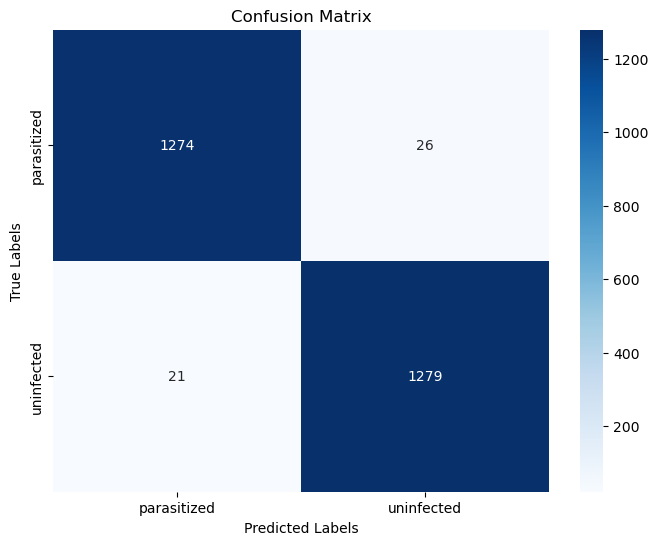

In [37]:

# Define the function to get true and predicted labels from the dataset
def get_true_and_pred_labels(dataset, model):
    ''' 
    A helper function uses prediction - to get the labels and compare
    against the true lable
    '''
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        # lets run the model for its prediction - see how it performs on dataset
        predictions = model.predict(images)
        #convert to class labels
        predicted_classes = np.argmax(predictions, axis=1)
        
        # Get the true labels (if one-hot encoded, convert them to class labels)
        true_classes = np.argmax(labels, axis=1)
        
        y_true.extend(true_classes)
        y_pred.extend(predicted_classes)
    
    return np.array(y_true), np.array(y_pred)

def plot_confusion_matrix( cm ):
    '''
    plot the confusion matrix mainly generated using the confusionMatrix api once the model fitting and evaluation is done.
    '''
    plt.figure(figsize=(8, 6))
    sns.heatmap( cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


# Get true and predicted labels from the test dataset
y_true, y_pred = get_true_and_pred_labels(test_ds_one_hot, cnn_base_model)

# Compute confusion matrix of true label to predicted label
cm = confusion_matrix(y_true, y_pred)

# plot the confusion matrix
plot_confusion_matrix(cm)


<b>Plotting the train and validation curves

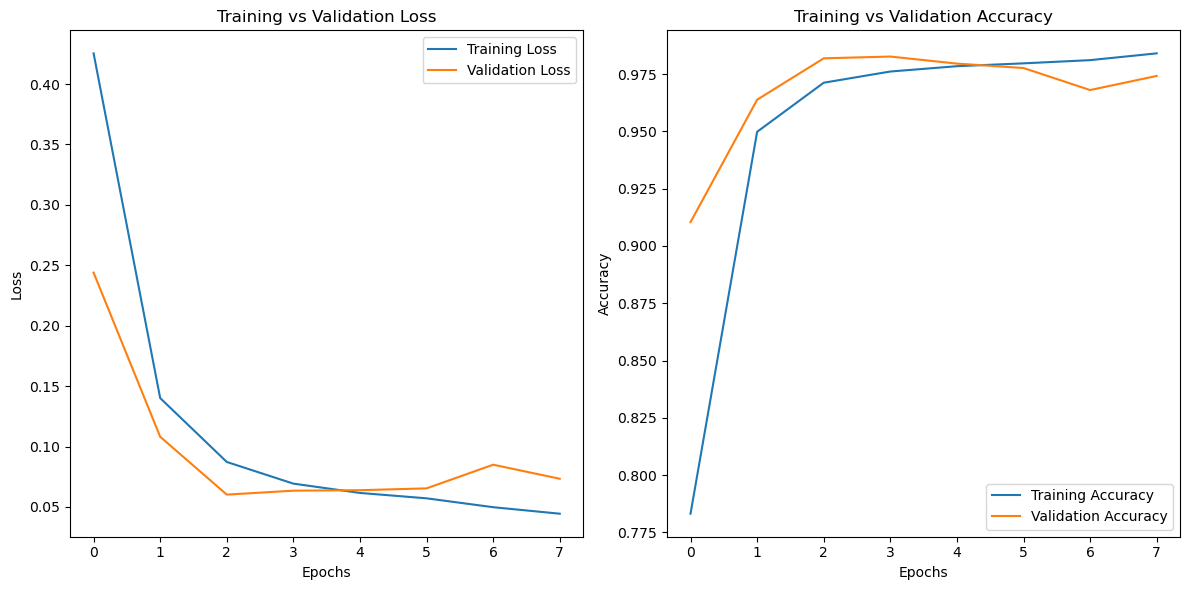

In [38]:
def plot_training_and_validation_graph( model_history ):
    '''
    A utility function that will take model_history an output of model fitting to plot the validation and training graphs for
    loss as well accuracy respectively.
    '''
    # Plot Training & Validation Loss
    plt.figure(figsize=(12, 6))

    # Plot Training loss
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['loss'], label='Training Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot the validation graph
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['accuracy'], label='Training Accuracy')
    plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # plot the graph
    plt.tight_layout()
    plt.show()

plot_training_and_validation_graph( cnn_base_model_fit )


<b>Performance of Basic Model</b> <br>
- computation speed   : 22s per epoch
- Training Accuracy   : 0.977, Loss: 0.063
- Validation Accuracy : 0.981, Loss: 0.060
- False Positive      : 21
- False Negative      : 26
- Total errors        : 47 out of 2600
- Results             : A promising start for the base model - especially the acuracy on test and validation data is coming very close.

<div class="alert alert-block alert-info">
<b>Model 2:</b> Improvization on Base model with added layers and LeakyRelu Activation
</div>

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [39]:
# Improved base Model with more layers and advanced activation functions
def create_advanced_cnn_model(num_classes=2):
    '''
    Improve on the base model
    change activation to Leaky Relu
    adding global average polling
    adding few more layers
    '''
    model = models.Sequential([
        # input size
        tf.keras.layers.Input(shape=(64, 64, 3)),
        
        # Layer 1 with LeakyReLU and max pooling of 2x2
        layers.Conv2D(32, (3, 3), activation='linear', padding='same'),
        layers.LeakyReLU(alpha=0.1),  # LeakyReLU activation
        layers.MaxPooling2D((2, 2)),
        
        # Layer 2 with Swish activtation and max pooling 2x2
        layers.Conv2D(64, (3, 3), activation='linear', padding='same'),
        layers.Activation(tf.keras.activations.swish),
        layers.MaxPooling2D((2, 2)),
        
        # laye 3 with LeakyReLU and alpha 0.1
        layers.Conv2D(128, (3, 3), activation='linear', padding='same'),
        layers.LeakyReLU(alpha=0.1),
        
        # Adding a global average pooling
        layers.GlobalAveragePooling2D(),
        
        # Add a dense layer
        layers.Dense(128, activation='relu'),
        # add a drop out layer
        layers.Dropout(0.5),  # Dropout to reduce overfitting
        
        # final layer with softmax activation
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

###<b> Building the Model

In [40]:
# create the cnn_model_2 - a little advance model than the base model
cnn_model_2 = create_advanced_cnn_model(num_classes=2)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


###<b> Compiling the model

In [41]:
# Compile the model with Adam optimizer and categorical crossentropy loss
cnn_model_2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
cnn_model_2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,018 (429.76 KB)

 Trainable params: 110,018 (429.76 KB)

 Non-trainable params: 0 (0.00 B)

<b> Using Callbacks

In [42]:
# we are going to use the same callback - not defining any new one.

<b>Fit and Train the model

In [43]:
# fit the model - in batch sizes.
cnn_model_2_hist = cnn_model_2.fit(train_ds_one_hot, batch_size=1000, epochs=20, validation_data= test_ds_one_hot, callbacks=[early_stopping,model_checkpoint])
cnn_model_2_hist.history

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.5846 - loss: 0.6686 - val_accuracy: 0.6573 - val_loss: 0.6362
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 141ms/step - accuracy: 0.7549 - loss: 0.5090 - val_accuracy: 0.9350 - val_loss: 0.2001
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 145ms/step - accuracy: 0.9425 - loss: 0.1759 - val_accuracy: 0.9500 - val_loss: 0.1378
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.9542 - loss: 0.1351 - val_accuracy: 0.9519 - val_loss: 0.1334
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 141ms/step - accuracy: 0.9595 - loss: 0.1174 - val_accuracy: 0.9554 - val_loss: 0.1262
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 141ms/step - accuracy: 0.9604 - loss: 0.1139 - val_accuracy: 0.9585 - val_loss: 0.1089
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 142ms/step - accuracy: 0.9638 - loss: 0.1028 - val_accuracy: 0.9531 - val_loss: 0.1266
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.9660 - loss: 0

{'accuracy': [0.6343056559562683,
  0.8303950428962708,
  0.9463098049163818,
  0.9568474888801575,
  0.9596922993659973,
  0.9622566103935242,
  0.9652215838432312,
  0.9661030769348145,
  0.9686673879623413,
  0.9691882133483887,
  0.9725939631462097,
  0.9738360643386841,
  0.9757592678070068,
  0.976159930229187,
  0.9771616458892822,
  0.9788444638252258,
  0.9786040782928467,
  0.979084849357605,
  0.9787642955780029],
 'loss': [0.6415977478027344,
  0.38925889134407043,
  0.16166113317012787,
  0.12765192985534668,
  0.1167946457862854,
  0.10727101564407349,
  0.10153181105852127,
  0.09792693704366684,
  0.09168471395969391,
  0.08693811297416687,
  0.08077885955572128,
  0.07735496014356613,
  0.07506749778985977,
  0.07028873264789581,
  0.0662815123796463,
  0.06427796930074692,
  0.06493496894836426,
  0.06151266396045685,
  0.06024834141135216],
 'val_accuracy': [0.6573076844215393,
  0.9350000023841858,
  0.949999988079071,
  0.9519230723381042,
  0.9553846120834351,
  0

###<b> Evaluating the model

In [44]:
# evaluate test and training data set for accuracy and loss - for model 2. these are very valuable attributes to compare the model.
e_train,e_test = evaluate_and_print_accuracy( cnn_model_2 )
model_list.append( ("Model 2: cnn_model_2",e_train,e_test) )
len(model_list)
# show the model list so far.
show_models_so_far()

250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9795 - loss: 0.0603
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9808 - loss: 0.0567
Training Accuracy: 0.979124903678894, Loss: 0.059495024383068085
Validation Accuracy: 0.982692301273346, Loss: 0.05070040374994278
('Model 1: cnn_base_model', [0.06356985867023468, 0.9778026938438416], [0.06023962050676346, 0.9819231033325195])
Model 1: cnn_base_model: test-accuracy:0.9819231033325195
Model 2: cnn_model_2: test-accuracy:0.982692301273346


The best model: Model 2: cnn_model_2, with test-accuracy: 0.982692301273346


<b> Plotting the confusion matrix

<b> Plotting the train and the validation curves

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


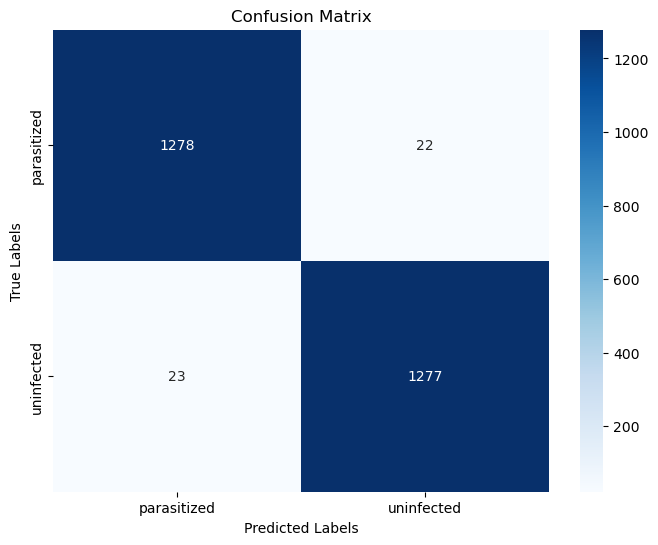

In [45]:
# lets predict and compute the confusion matrix
y_true, y_pred = get_true_and_pred_labels(test_ds_one_hot, cnn_model_2)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix( cm )

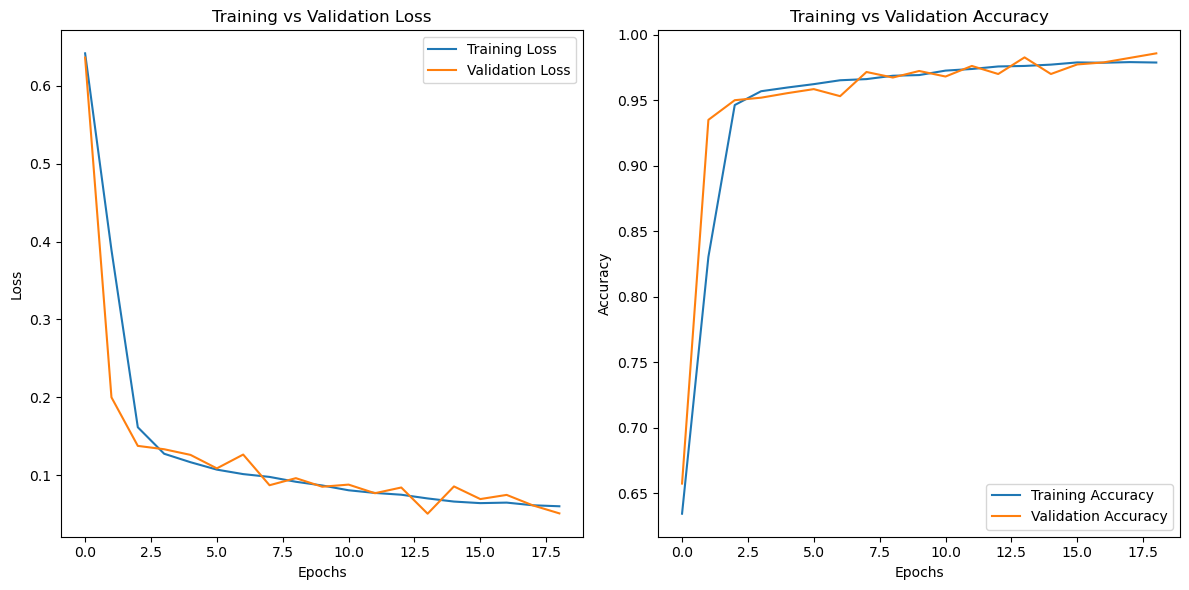

In [46]:
# plot training and validation graph for model 2.
plot_training_and_validation_graph( cnn_model_2_hist )

<b>Observations: Model#2</b> <br>
<p>
This model is successful in terms of modeling the accuracy and loss. This model also runs full life cycle of 20 epochs. The full run absolutely trains model better. Alongside it also improves accurcay and loss.

The confustion metrix show promising numbers on errors compared to based model. However the model accuracy on the test set is better - the confusion errors are little more than the base model.
The accuracy is better than the base model
</p>

<b>Performance of Model 2</b> <br>
- computation speed   : 35 second per epoch
- Training Accuracy   : 0.979, Loss: 0.059
- Validation Accuracy : 0.982, Loss: 0.050
- False Positive      : 23
- False Negative      : 22
- Total errors        : 45 out of 2600
- Results             : A strong performing model with better accuracy rate however two extra f/p and f/n from the base model.

A training and validation accuracy toward the end of the epoch goes hand in hand it consolidates pretty good.

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

<div class="alert alert-block alert-info">
<b>Model 3:</b> A Model 2 improvized with Batch normalization alyer as well as Squeeze and excited block
</div>

###<b> Model 2 with Batch Normalization

In [47]:
# SE Block Definition
def squeeze_excite_block(input_tensor, ratio=8):
    ''' 
    adding squeeze and excite block to further advance the model
    '''
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, channels))(se)
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Multiply()([input_tensor, se])
    return se

# Enhanced CNN Model with Batch Normalization, Dropout, and additional layers
def create_advanced_cnn2_model(num_classes=2):
    input_layer = tf.keras.layers.Input(shape=(64, 64, 3))
    
    # Convolutional Layer 1 with LeakyReLU and Batch Normalization
    x = layers.Conv2D(32, (3, 3), activation='linear', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)  # LeakyReLU activation
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Convolutional Layer 2 with Swish and Batch Normalization
    x = layers.Conv2D(64, (3, 3), activation='linear', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(tf.keras.activations.swish)(x)  # Swish activation
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Convolutional Layer 3 with LeakyReLU and Batch Normalization
    x = layers.Conv2D(128, (3, 3), activation='linear', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    # Convolutional Layer 4 (Added) with Batch Normalization and LeakyReLU
    x = layers.Conv2D(128, (3, 3), activation='linear', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    # Apply Squeeze and Excitation block here (directly to the output tensor)
    x = squeeze_excite_block(x, ratio=8)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully Connected Layer with Dropout
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Dropout to reduce overfitting
    
    # Additional Fully Connected Layer (Added)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Output Layer (softmax for classification)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)
    
    # Define the model
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

###<b> Building the Model

In [48]:
# Compile this advance model with squeeze and excite block
cnn_adv2_model = create_advanced_cnn2_model(num_classes=2)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


###<b>Compiling the model

In [49]:
# Compile the model with Adam optimizer and categorical crossentropy loss
cnn_adv2_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Print the summary of the model
cnn_adv2_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ leaky_re_lu_2[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    147,584 │ leaky_re_lu_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ leaky_re_lu_4[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 128) │          0 │ global_average_p

 Total params: 271,378 (1.04 MB)

 Trainable params: 270,674 (1.03 MB)

 Non-trainable params: 704 (2.75 KB)

<b> Using callbacks

In [50]:
# will use the same call backs

<b>Fit and train the model

In [51]:
# fit the model  for the training dataset
cnn_adv2_model_hist = cnn_adv2_model.fit(train_ds_one_hot, batch_size=1000, epochs=20, validation_data= test_ds_one_hot, callbacks=[early_stopping,model_checkpoint]  )
cnn_adv2_model_hist.history

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 270ms/step - accuracy: 0.7946 - loss: 0.4272 - val_accuracy: 0.5565 - val_loss: 1.3513
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 279ms/step - accuracy: 0.9716 - loss: 0.0926 - val_accuracy: 0.9635 - val_loss: 0.1192
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 295ms/step - accuracy: 0.9763 - loss: 0.0772 - val_accuracy: 0.9750 - val_loss: 0.0610
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.9779 - loss: 0.0693 - val_accuracy: 0.9804 - val_loss: 0.0725
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 271s 255ms/step - accuracy: 0.9793 - loss: 0.0664 - val_accuracy: 0.5000 - val_loss: 1.5079
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 269ms/step - accuracy: 0.9757 - loss: 0.0788 - val_accuracy: 0.9804 - val_loss: 0.0793
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.9795 - loss: 0.0609 - val_accuracy: 0.9823 - val_loss: 0.0548
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 187s 751ms/step - accuracy: 0.9815 - loss: 0

{'accuracy': [0.8936212658882141,
  0.9725939631462097,
  0.976600706577301,
  0.9783235788345337,
  0.9746373891830444,
  0.976600706577301,
  0.9802468419075012,
  0.9812484979629517,
  0.9814087748527527,
  0.9814488291740417,
  0.9808077812194824,
  0.9816091060638428,
  0.9832919239997864,
  0.9830515384674072,
  0.9834522008895874],
 'loss': [0.26206496357917786,
  0.09010068327188492,
  0.07681237906217575,
  0.06663845479488373,
  0.07780326902866364,
  0.07538236677646637,
  0.058103665709495544,
  0.0552717000246048,
  0.05200536176562309,
  0.051205653697252274,
  0.05298036336898804,
  0.04978768527507782,
  0.04637640342116356,
  0.04659794270992279,
  0.04517481476068497],
 'val_accuracy': [0.556538462638855,
  0.9634615182876587,
  0.9750000238418579,
  0.9803845882415771,
  0.5,
  0.9803845882415771,
  0.9823076725006104,
  0.9830769300460815,
  0.9834615588188171,
  0.986923098564148,
  0.983846127986908,
  0.9846153855323792,
  0.9865384697914124,
  0.9842307567596436

<b>Plotting the train and validation accuracy

In [52]:
#cache the model list - for final result display and evaluate the test and training data set for accuracy.
e_train, e_test = evaluate_and_print_accuracy(cnn_adv2_model)
model_list.append( ("Model 3: cnn_adv2_model",e_train,e_test) )
len(model_list)
show_models_so_far()

250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.9811 - loss: 0.0528
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9867 - loss: 0.0396
Training Accuracy: 0.9815289974212646, Loss: 0.051274318248033524
Validation Accuracy: 0.986923098564148, Loss: 0.03757196664810181
('Model 1: cnn_base_model', [0.06356985867023468, 0.9778026938438416], [0.06023962050676346, 0.9819231033325195])
Model 1: cnn_base_model: test-accuracy:0.9819231033325195
Model 2: cnn_model_2: test-accuracy:0.982692301273346
Model 3: cnn_adv2_model: test-accuracy:0.986923098564148


The best model: Model 3: cnn_adv2_model, with test-accuracy: 0.986923098564148


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


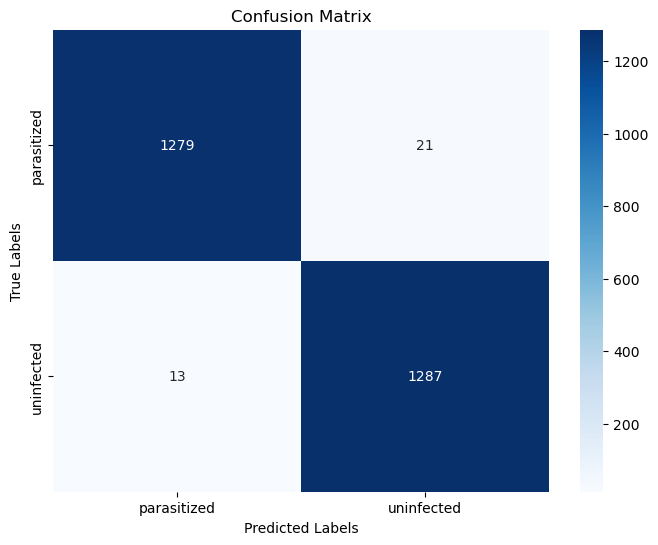

In [53]:
# Get true and predicted labels from the test dataset
y_true, y_pred = get_true_and_pred_labels(test_ds_one_hot, cnn_adv2_model )
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
# plot the confusino metrics for the model 3
plot_confusion_matrix( cm )

###<b>Evaluating the model

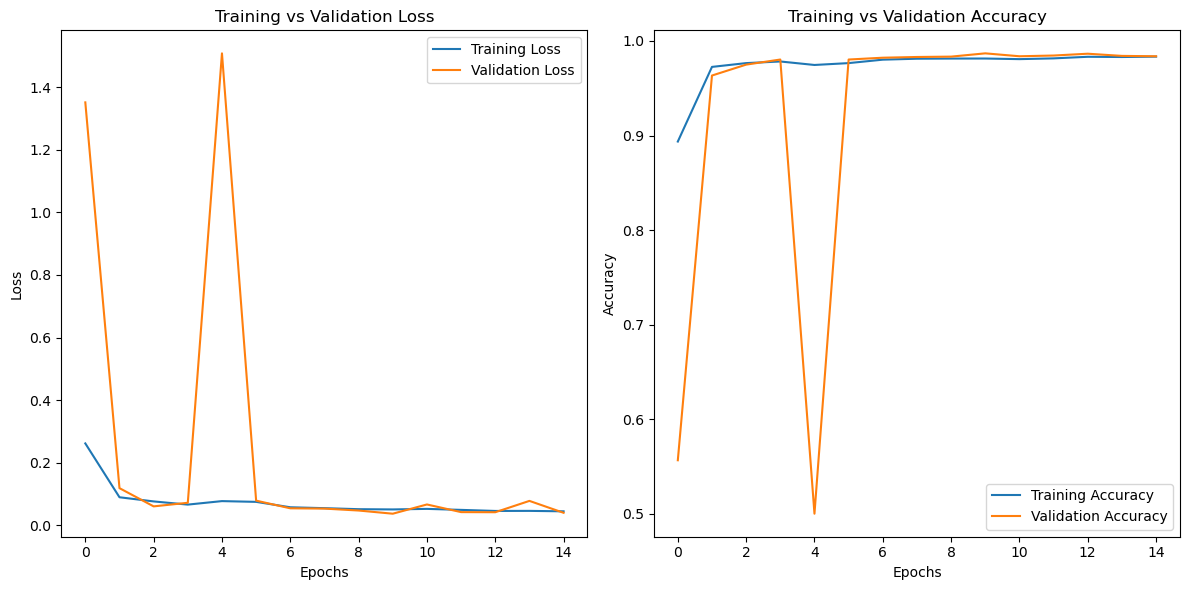

In [54]:
plot_training_and_validation_graph( cnn_adv2_model_hist )

<b> Generate the classification report and confusion matrix 

<b>####<Observations and insights:</b><br>
<b>Observations: Model#3 : A model with squeeze and excite layer</b> <br>
<br><p>
This model definitely performs better than the previous two models - especially looking at the absolute numbers of the errors (including false negative + false positive). Their certain epochs are not on trend of improving its accuracy as well as loss but overall the model flattens out fine.

The only drawback is training the model for the dataset - it is higher side on time taken in steps compared to model 2 - which can be improved by going with high-compute if it is cheap. Otherwise it can be one concern.
</p>

<b>Performance of Model 3 with squeeze and excite layer</b> <br>
- computation speed   : 100s per epoch
- Training Accuracy   : 0.981, Loss: 0.051
- Validation Accuracy : 0.986, Loss: 0.037
- False Positive      : 13
- False Negative      : 21
- Total errors        : 34 out of 2600
- Results             : So far the best model - in terms of validation accuracy as well as confusion matrix. The performance is degraded compared to model 2 but absolute number is better - there are not very different.
There is spike around epoch 4. It also shos the training and validation curve almost becoming one. hence the best performance so far.
It is also reflected in to fp/fn numbers.


###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





<div class="alert alert-block alert-info">
<b>Model 4:</b> A Model with Data augmentation layer - improvation on Model 2 - only the images are augmented
</div>

###<b>Model 3 with Data Augmentation

In [55]:
# nothing here

###<b> Use image data generator

In [56]:
# The images are stored in TensorFlow.MapData set - which combines iamges, label into various batch
# using ImageGenerator is not available directly. Instead the below function applies the image augmentation 
# using random morphing of the image with certain feature os image transformation. This function
# will be used as mapping function of the original image and then we will use the same image for our training
# of the data.

# Define a function for augmentations (this will act like the "map" function)
def data_augmentation(image, label):
    # Apply random transformations here
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    return image, label

# lets map the training data set with the image augmentaiton
# this shall be used in the model fitting.. no need to augment the testing dataset right
ds_augmented = train_ds.map(data_augmentation)

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

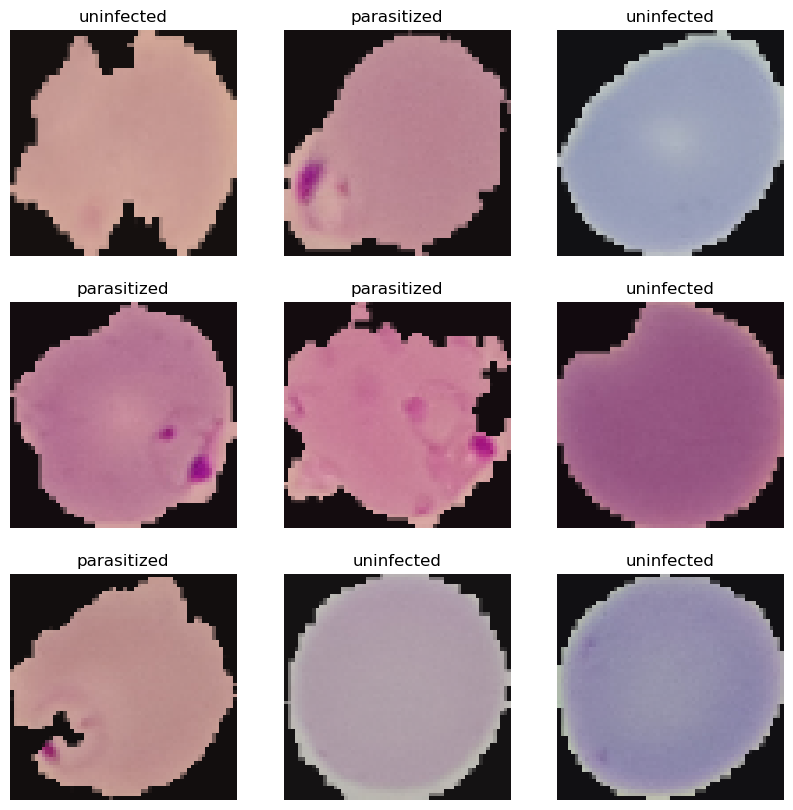

In [57]:
# show 3x3 data augmented layer - so that we can see if it makes more sense - or can be easily differentiate
show_3_by_3_image_of_dataset(ds_augmented)

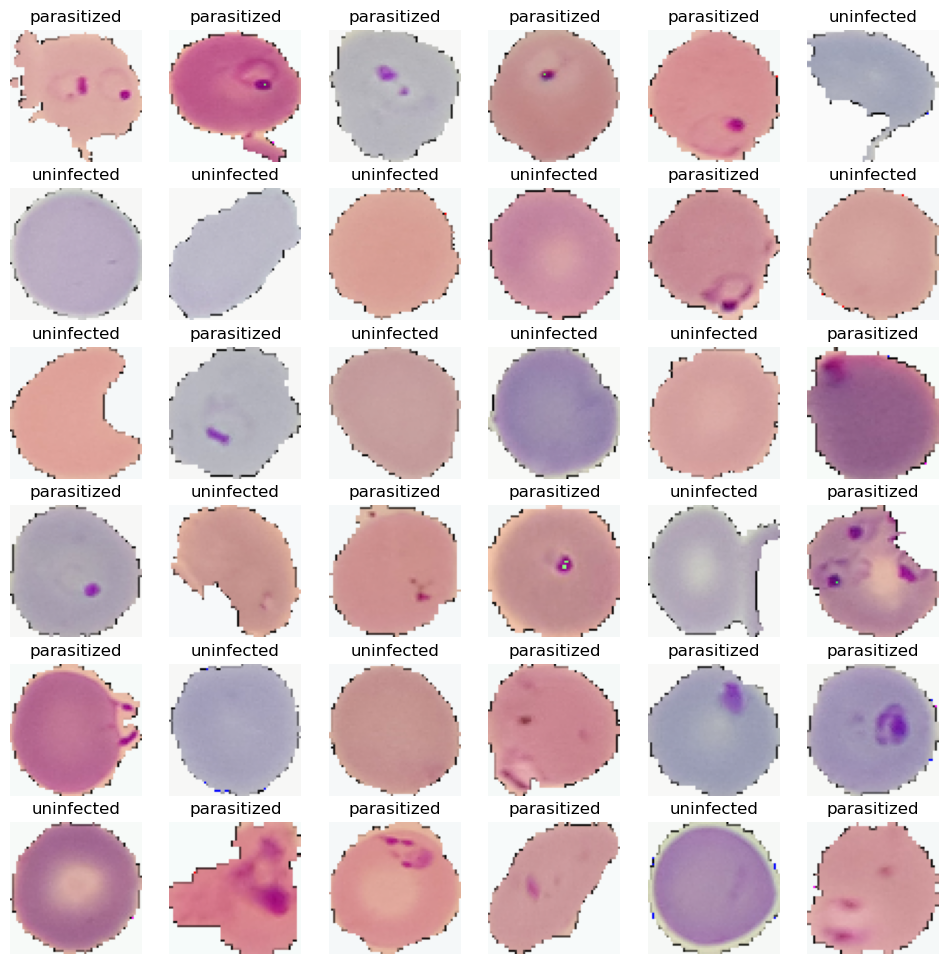

In [58]:
# show 6x6 images of augmented images.
show_6_by_6_image_of_dataset(ds_augmented)

####<b>Observations and insights:</b><br>

<p>
It's a definite improvment certain - you can see the images little different than the original RGB images - lets give it a try to use the data augmented images into model to see how it performs. The real test of the model performance and error rate shall provide use more idea.
</p>

###<b>Building the Model with Image augmentation image</b>

In [59]:
# Improved Adv Model with data augmentation layer
def create_advanced3_cnn_model(num_classes=2):
    '''
    this is the model 1 - after the base model becuase its performance is on par 
    with the model 2
    '''
    model = models.Sequential([
        # input size
        tf.keras.layers.Input(shape=(64, 64, 3)),
        
        # Layer 1 with LeakyReLU and max pooling of 2x2
        layers.Conv2D(32, (3, 3), activation='linear', padding='same'),
        layers.LeakyReLU(alpha=0.1),  # LeakyReLU activation
        layers.MaxPooling2D((2, 2)),
        
        # Layer 2 with Swish activtation and max pooling 2x2
        layers.Conv2D(64, (3, 3), activation='linear', padding='same'),
        layers.Activation(tf.keras.activations.swish),
        layers.MaxPooling2D((2, 2)),
        
        # Layer 3 with LeakyReLU and alpha 0.1
        layers.Conv2D(128, (3, 3), activation='linear', padding='same'),
        layers.LeakyReLU(alpha=0.1),
        
        # Adding a global average pooling
        layers.GlobalAveragePooling2D(),
        
        # Add a dense layer
        layers.Dense(128, activation='relu'),
        
        # Add a dropout layer
        layers.Dropout(0.5),  # Dropout to reduce overfitting
        
        # Final layer with softmax activation
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


<b>Using Callbacks

In [60]:
# not going to use any callbacks for stopping the model - lets go through the 20 epochs

<b> Fit and Train the model

In [61]:
# Map the data augmentation function onto the dataset
train_ds_augmented = train_ds_one_hot.map(data_augmentation)

# Create the model which is model 2 - only
cnn_adv3_model = create_advanced3_cnn_model(num_classes=2)

# Compile the model
cnn_adv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model using augmented data it only training data shall be augmented
# for the testing we shall use the regular data.
cnn3_augmented_model_history = cnn_adv3_model.fit(train_ds_augmented, epochs=20,batch_size=1000, validation_data= test_ds_one_hot )


Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 137ms/step - accuracy: 0.5732 - loss: 0.6789 - val_accuracy: 0.6050 - val_loss: 0.7324
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 142ms/step - accuracy: 0.7288 - loss: 0.5708 - val_accuracy: 0.8838 - val_loss: 0.3077
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 150ms/step - accuracy: 0.9023 - loss: 0.2782 - val_accuracy: 0.9208 - val_loss: 0.2069
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 151ms/step - accuracy: 0.9291 - loss: 0.1998 - val_accuracy: 0.9508 - val_loss: 0.1477
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 151ms/step - accuracy: 0.9464 - loss: 0.1550 - val_accuracy: 0.9335 - val_loss: 0.1505
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 151ms/step - accuracy: 0.9530 - loss: 0.1310 - val_accuracy: 0.9658 - val_loss: 0.1153
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 151ms/step - accuracy: 0.9579 - loss: 0.1185 - val_accuracy: 0.9627 - val_loss: 0.1155
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 224ms/step - accuracy: 0.9478 - loss: 0.1414 - val

In [62]:
# print model summary for the augmented model - it is based on model 2 only the input is different.
cnn_adv3_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 330,056 (1.26 MB)

 Trainable params: 110,018 (429.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 220,038 (859.53 KB)

###<B>Evaluating the model

<b>Plot the train and validation accuracy

In [63]:
e_train, e_test = evaluate_and_print_accuracy( cnn_adv3_model )
model_list.append( ("Model 4: cnn_adv3_model (image aug)",e_train,e_test) )
len(model_list)
show_models_so_far()

250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9794 - loss: 0.0612
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9813 - loss: 0.0626
Training Accuracy: 0.9795656800270081, Loss: 0.06038351356983185
Validation Accuracy: 0.9815384745597839, Loss: 0.061792146414518356
('Model 1: cnn_base_model', [0.06356985867023468, 0.9778026938438416], [0.06023962050676346, 0.9819231033325195])
Model 1: cnn_base_model: test-accuracy:0.9819231033325195
Model 2: cnn_model_2: test-accuracy:0.982692301273346
Model 3: cnn_adv2_model: test-accuracy:0.986923098564148
Model 4: cnn_adv3_model (image aug): test-accuracy:0.9815384745597839


The best model: Model 3: cnn_adv2_model, with test-accuracy: 0.986923098564148


<B>Plotting the classification report and confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


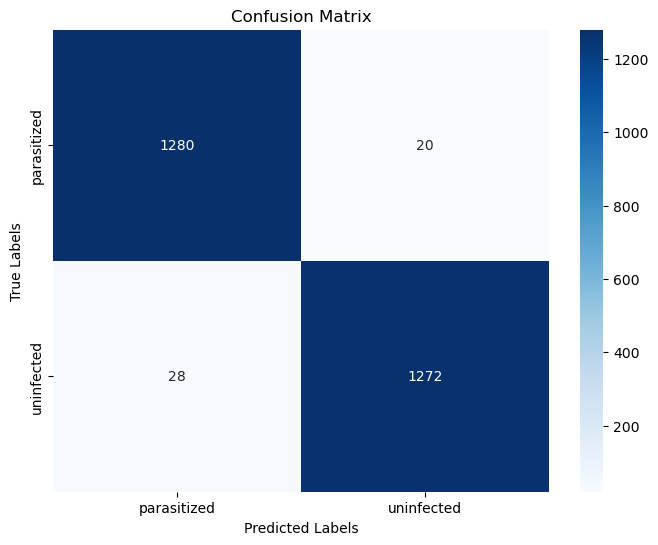

In [64]:
# Get true and predicted labels from the test dataset for the augmented model
y_true, y_pred = get_true_and_pred_labels(test_ds_one_hot, cnn_adv3_model)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
# plot a chart for the confusion matrix
plot_confusion_matrix( cm )


<b>Observations: Model#4 : A model with Image Augmentaion</b> <br>
<p>
A presentation of modified images was really interesting on the previous chart - how if we look at the errors - especially false positive/negative numbers have gone up. The same model performed well on regular RGB but here it is shown to have performance degradation on average too. 
It is a good experiment but definitely did not perform on the error level as contender.
</p>

<b>Performance of Advance Model#4</b> <br>
- computation speed   : 35s per epoch
- Training Accuracy   : 0.979, Loss: 0.060
- Validation Accuracy : 0.981, Loss: 0.061
- False Positive      : 28
- False Negative      : 20
- Total errors        : 48 out of 2600
- Results             : Can not beat Model 2 and Model 3's accuracy. confusion matrix is little high also the accuracy is less - it does not worth the effort to image augment for the base 2 model - which does work better.


<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

<div class="alert alert-block alert-info">
<b>Model5 :</b> Pre-trained VGG16 model
</div>

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [65]:
from tensorflow.keras.applications import VGG16

# creates VGG16 model with pre-trained weights from ImageNet, excluding the top classification layers
def create_vgg16_model(num_classes=2):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    
    # Freeze the layers in the base VGG16 model to avoid retraining them
    for layer in base_model.layers:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        # add globalAverage pooling layer
        layers.GlobalAveragePooling2D(),
        # add relu activation
        layers.Dense(128, activation='relu'),
        # reduce overfitting
        layers.Dropout(0.5),
        # final classification layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

###<b>Compiling the model

In [66]:
# 2. Create the VGG16 model
cnn_vgg16_model = create_vgg16_model(num_classes=2)

# 3. Compile the model
cnn_vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

<b> using callbacks

In [67]:
# using the same callbacks.

<b>Fit and Train the model

In [68]:
# 4. Fit the model using normalized train and test data for validation
vgg16_model_history = cnn_vgg16_model.fit(
    train_ds_one_hot,  
    epochs=20, 
    batch_size = 1000,
    validation_data=test_ds_one_hot
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.7897 - loss: 0.4371 - val_accuracy: 0.9227 - val_loss: 0.2116
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 232s 928ms/step - accuracy: 0.9181 - loss: 0.2125 - val_accuracy: 0.9331 - val_loss: 0.1771
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 225s 902ms/step - accuracy: 0.9316 - loss: 0.1828 - val_accuracy: 0.9327 - val_loss: 0.1629
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.9359 - loss: 0.1742 - val_accuracy: 0.9358 - val_loss: 0.1654
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 229s 916ms/step - accuracy: 0.9382 - loss: 0.1654 - val_accuracy: 0.9404 - val_loss: 0.1492
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.9397 - loss: 0.1611 - val_accuracy: 0.9396 - val_loss: 0.1478
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 201s 805ms/step - accuracy: 0.9434 - loss: 0.1563 - val_accuracy: 0.9438 - val_loss: 0.1409
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 222s 886ms/step - accuracy: 0.9413 - loss: 0.

<b>Plot the train and validation accuracy

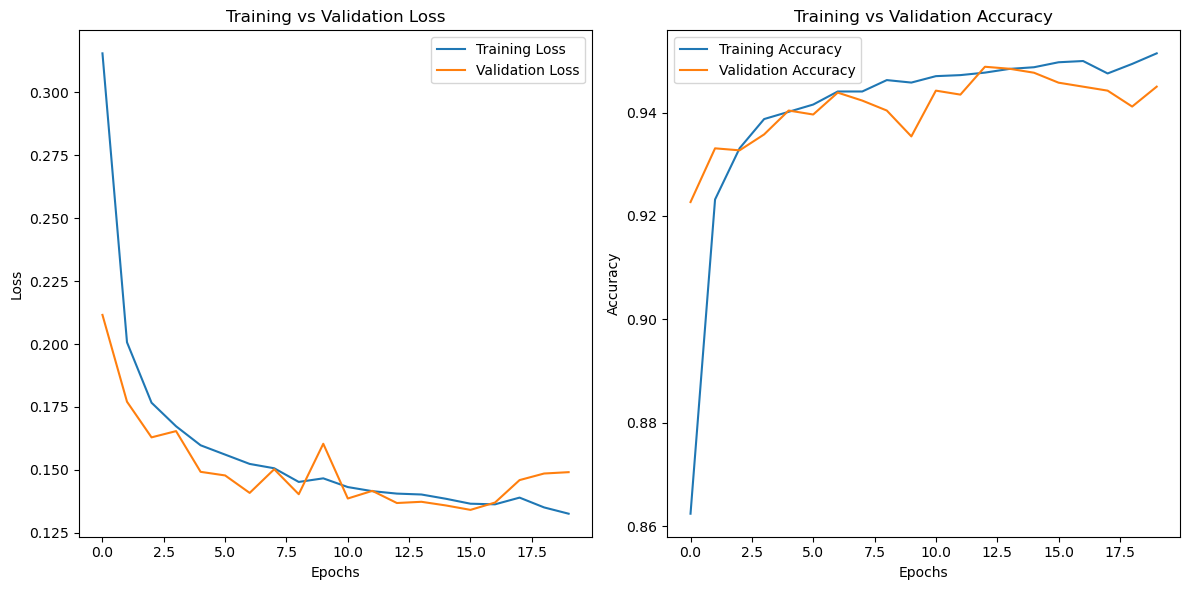

In [69]:

plot_training_and_validation_graph(vgg16_model_history)

<b>###**Observations and insights:**</b>

*   What can be observed from the validation and train curves? <br>
<p>
As the epoch progress we see the consolidation of accuracy agains the val_accuracy. However the loss is still open and does not fully match with the val_loss that means there might be more errors on the model in confusion matrix.
the performance is the worse of all model - it is using the imagenet weights - if we try with unknown - weights the performance goes even down further.
</p>

###<b> Evaluating the model

In [70]:
# evaluation of the model 5 - vgg16 and its true label comparisions.
e_train,e_test = evaluate_and_print_accuracy( cnn_vgg16_model )
model_list.append( ("Model 5: cnn_vgg16_model",e_train,e_test) )
len(model_list)
show_models_so_far()

250/250 ━━━━━━━━━━━━━━━━━━━━ 221s 885ms/step - accuracy: 0.9543 - loss: 0.1198
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 896ms/step - accuracy: 0.9468 - loss: 0.1487
Training Accuracy: 0.9562865495681763, Loss: 0.11671894788742065
Validation Accuracy: 0.9449999928474426, Loss: 0.14911305904388428
('Model 1: cnn_base_model', [0.06356985867023468, 0.9778026938438416], [0.06023962050676346, 0.9819231033325195])
Model 1: cnn_base_model: test-accuracy:0.9819231033325195
Model 2: cnn_model_2: test-accuracy:0.982692301273346
Model 3: cnn_adv2_model: test-accuracy:0.986923098564148
Model 4: cnn_adv3_model (image aug): test-accuracy:0.9815384745597839
Model 5: cnn_vgg16_model: test-accuracy:0.9449999928474426


The best model: Model 3: cnn_adv2_model, with test-accuracy: 0.986923098564148


<b>Plotting the classification report and confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 

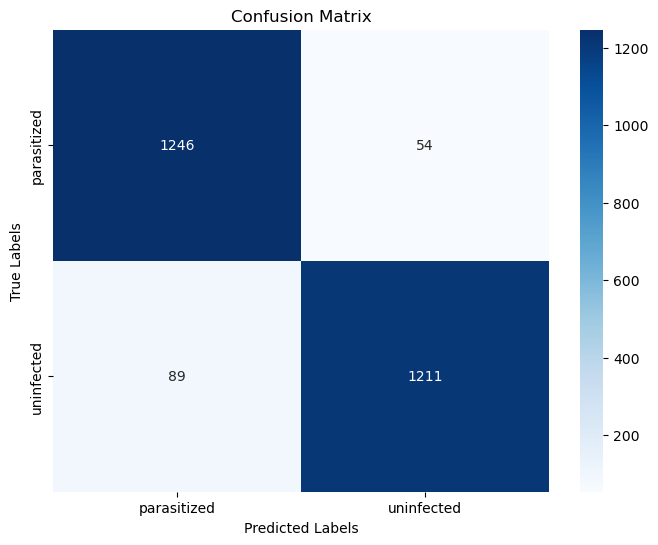

In [71]:
# Get true and predicted labels from the test dataset
y_true, y_pred = get_true_and_pred_labels(test_ds_one_hot, cnn_vgg16_model)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix( cm )

<b>Observations: Model#5 : a vgg16 model</b> <br>
<p>
I expected the performance to be better but first - when i performed the model fit on the first time - it was very slow on the average 20s per steps on epoch. Then i modified to use the imagenet weights it did much better at 964 ms per steps on epoch. 

However compared to all the model this has the worse performance. the confusion matrix also show the worse result. 
</p>
Training Accuracy: 0.9562865495681763, Loss: 0.11671894788742065
Validation Accuracy: 0.9449999928474426, Loss: 0.14911305904388428

<b>Performance of Pre-trained Model#5 (VGG16)</b> <br>
- computation speed   : 300s per epoch
- Training Accuracy   : 0.956, Loss: 0.116
- Validation Accuracy : 0.944, Loss: 0.149
- False Positive      : 89
- False Negative      : 54
- Total errors        : 143 out of 2600

this is the worse performing model in terms of time. May be there might be better way to use this model by tuning the weights or hyper parameters. However in terms of graph - training and evaluation accuracy - the final results are way off - you can see the impact of the same in confusion matrics as well as the error rate.

The time taken by this model to fit the trainig data set is exhorbitant keep in mind for the custom weight the time is even worse. Notice training vs validation chart the final epochs they are diverging significantly and you can see it opening up.

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


In [72]:
print("The final comparision of the total 5 models so far:")
show_models_so_far()

The final comparision of the total 5 models so far:
('Model 1: cnn_base_model', [0.06356985867023468, 0.9778026938438416], [0.06023962050676346, 0.9819231033325195])
Model 1: cnn_base_model: test-accuracy:0.9819231033325195
Model 2: cnn_model_2: test-accuracy:0.982692301273346
Model 3: cnn_adv2_model: test-accuracy:0.986923098564148
Model 4: cnn_adv3_model (image aug): test-accuracy:0.9815384745597839
Model 5: cnn_vgg16_model: test-accuracy:0.9449999928474426


The best model: Model 3: cnn_adv2_model, with test-accuracy: 0.986923098564148


####<b> Observations and Conclusions drawn from the final model:</b>
The final comparision of the total 5 models so far: 

- Model 1: cnn_base_model: test-accuracy:0.9819231033325195
- Model 2: cnn_model_2: test-accuracy:0.982692301273346
- Model 3: cnn_adv2_model: test-accuracy:0.986923098564148
- Model 4: cnn_adv3_model (image aug): test-accuracy:0.9815384745597839
- Model 5: cnn_vgg16_model: test-accuracy:0.9449999928474426

<b>The best model: Model 3: cnn_adv2_model, with test-accuracy: 0.986923098564148</b>
<br>
<p>
For the conclusion: the model 3 - with sequeeze and excite block is the best performing mmodel. A model 2 comes at the second best in terms of accuracy. The confusion matrix shows lowest false values as well as accuracy of the model at 0.986 on test validation.
I prefer the model 3 over rest pof the model as its performance is great. It has its accuracy at best one of the least fp/fn as well on the confustion metrix. A leakyRelu activation with squeeze and excited block does not burden the performance and at the same time smoothes the training of the model over number of epochs.
Model 3 - with Sqeeze and Excite is my final choice for this project. 
<div class="alert alert-block alert-info">
<b>Final Model : Model 3 - with Sequeeze and Excite bock</b> Test-Accuracy : 0.986 and False results : 34 numbers out of 2600
</div>

**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?
<p>
If there is clear way to distinguish the patterns in the image - there is a possibilities for the model to work. The data provided was balance so not much data preparation needed - however in real life problems one has to think about preparing data.

Also applying HSV and blurring didn't help in this case - especially as RGB image were most distinguishable images so the model performing on these images are definitly showing better results.

A image augmentation did help to notice subtle differences more clear - which means in real life problem one has to try different way to visual image. One trial is to do may be monochrome image and see if there are any patterns that can be derived.

</p>

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?
<p>
One thing i noticed is based CNN model with LeakyRelu performed - in model 2 - a best - i am going with Model 3 - but the performance of Model 3 is little off compared to model 2. However their results are pretty similar.
In terms of problem solving you may want to stick with a model that is performing faster - so that multiple iterations can be done - without wasting your time and effort. 

Once fine tuned - it will be better to add few complication on top which you surely know that is not going to degraded performance

On model 3 - training vs validation accuracy one can easily see near 4th epoch a loss is highest and validation is 0. This happens pretty much everytime. I realized that what makes the model better may be because it may be kicking on the extra layer - of squeeze and excites.

The more and more added layers - does not improve the accuracy by the amount we hoped would but at the same time it reduces the processing time.
</p>

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?
<p>
In terms of performance on my two machines - i would select model 3 - with squeeze and select. The reason for it is very deccent perfomance numbers on Apple Mac M1 with 16 GB and Macbook Air M3 with 16 GB. 
It has the lowest false/positive across board by the numbers.
It has the highest accuracy results for the test validation set.

It does the job and it does not drain my compute resources or need special compute device if i have to train, hypertune parameters and so on so forth. In the real life deploying a solution which is easy, adaptive and incremental is always better. Becuase you may not stick with the model forever you will need an improvement and if the model is heavy to build and fit - deploying would required special resource and it may not justify the cost.

Also the accuracy - and false negative/positive numbers are best of this model. So may final propsal for the model is Model 3.

</p>